In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantMonitor4Params

In [5]:
from verified_twin.lbuc import *
import sage.all as sg
from sage.all import RIF

In [6]:
sg.var("T_A", "T_H")

(T_A, T_H)

In [7]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

In [8]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

/home/sage/sage/local/lib/python3.9/site-packages/control/xferfcn.py:1498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(data[i][j][k], (int, np.int)):


In [9]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [10]:
properties = [
    Atomic(T_A < RIF(35)),
    G(RIF(0, 1000), Atomic(T_A > RIF(32))),
    G(RIF(0, 1000), ~Atomic(T_A < RIF(34))
                  | G(RIF(0, 50), Atomic(T_A > RIF(32)))
                  & F(RIF(0,50), Atomic(T_A > RIF(34)))),
    Atomic(T_A < RIF(85)),
    G(RIF(0, 1000), Atomic(T_A < RIF(85))),
    Atomic(T_H < RIF(130)),
]

## Self-Adaptation Loop Integration

In [11]:
config = load_config("startup.conf")

n_samples_period = config["physical_twin"]["controller_open_loop"]["n_samples_period"]
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 10
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 6000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

verified_monitor = VerifiedPlantMonitor4Params(properties)

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer,
                                         verified_monitor,
                                         lookahead_time=500.0)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
                                   trigger_optimization_threshold, heater_underused_threshold,
                                   wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 1000 else (G_box * 10 if m.time() < 2000 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


running verified monitoring for anomaly between times 1002.5938409201124 and 1035.5938409201124
x = [1002.5938409201124?, 118.89228178690598, 81.23814632391037]
state = {'heater_on': False, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1017.59384092?, 112.527264?, 54.42682?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1032.59384092?, 104.88858?, 43.95630?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1047.59384092?, 105.10438?, 39.84384?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1062.59384092?, 97.21012?, 37.79207?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       5.99459384e+03, 5.99759384e+03, 6.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.994

In [12]:
G(RIF(5,10), Atomic(T_H)).duration

10.0000000000000

In [13]:
m.self_adaptation_manager.state_machine.anomaly_durations

[(1002.5938409201124, 1035.5938409201124),
 (1068.5938409201124, 1101.5938409201124),
 (2010.5938409201124, 2043.5938409201124)]

In [14]:
m.self_adaptation_manager.state_machine.anomaly_parameters

[(1002.5938409201124,
  1502.5938409201124,
  81.23814632391037,
  118.89228178690598,
  21,
  3.0,
  10,
  5,
  141.71945977643318,
  7.8338353184845495,
  227.76228512,
  1.92343277),
 (1068.5938409201124,
  1568.5938409201124,
  38.48557931545541,
  103.27713248422768,
  21,
  3.0,
  10,
  5,
  272.01832249938576,
  8.315644265351954,
  227.76228512,
  1.92343277),
 (2010.5938409201124,
  2510.5938409201126,
  32.607154528547476,
  59.77326802388883,
  21,
  3.0,
  10,
  0,
  102.28707795820601,
  1.412942235649828,
  227.76228512,
  1.92343277)]

In [15]:
m.self_adaptation_manager.state_machine.verified_monitoring_results

[[Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 1113.5219342050635], False), ([1113.5219843513029 .. 2552.5938409201126], True)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], False)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], False)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], True)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 1552.5938409201126], True)], mask=None),
  Signal([1002.5938409201123 .. 2552.5938409201126], [([1002.5938409201123 .. 2552.5938409201126], True)], mask=None)],
 [Signal([1068.5938409201123 .. 2618.5938409201126], [([1068.5938409201123 .. 1114.6680420559520], False), ([1114.6680508244801 .. 2618.5938409201126], True)], mask=None),
  Signal([1068.5938409201123 .. 2618.5938409201126], [([10

### Manually do some verified simulation for anomolies

#### Anomaly 1

In [16]:
m.self_adaptation_manager.state_machine.anomaly_parameters[0]

(1002.5938409201124,
 1502.5938409201124,
 81.23814632391037,
 118.89228178690598,
 21,
 3.0,
 10,
 5,
 141.71945977643318,
 7.8338353184845495,
 227.76228512,
 1.92343277)

In [17]:
verified_trace1, verified_model1 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[0])
verified_sigs1 = m.self_adaptation_manager.state_machine.verified_monitoring_results[0]

x = [1002.5938409201124?, 118.89228178690598, 81.23814632391037]
state = {'heater_on': False, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1017.59384092?, 112.527264?, 54.42682?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1032.59384092?, 104.88858?, 43.95630?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1047.59384092?, 105.10438?, 39.84384?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1062.59384092?, 97.21012?, 37.79207?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1077.59384092?, 97.81909?, 36.70032?]
state = {'heater_on': False, 'current_state': <OpenLo

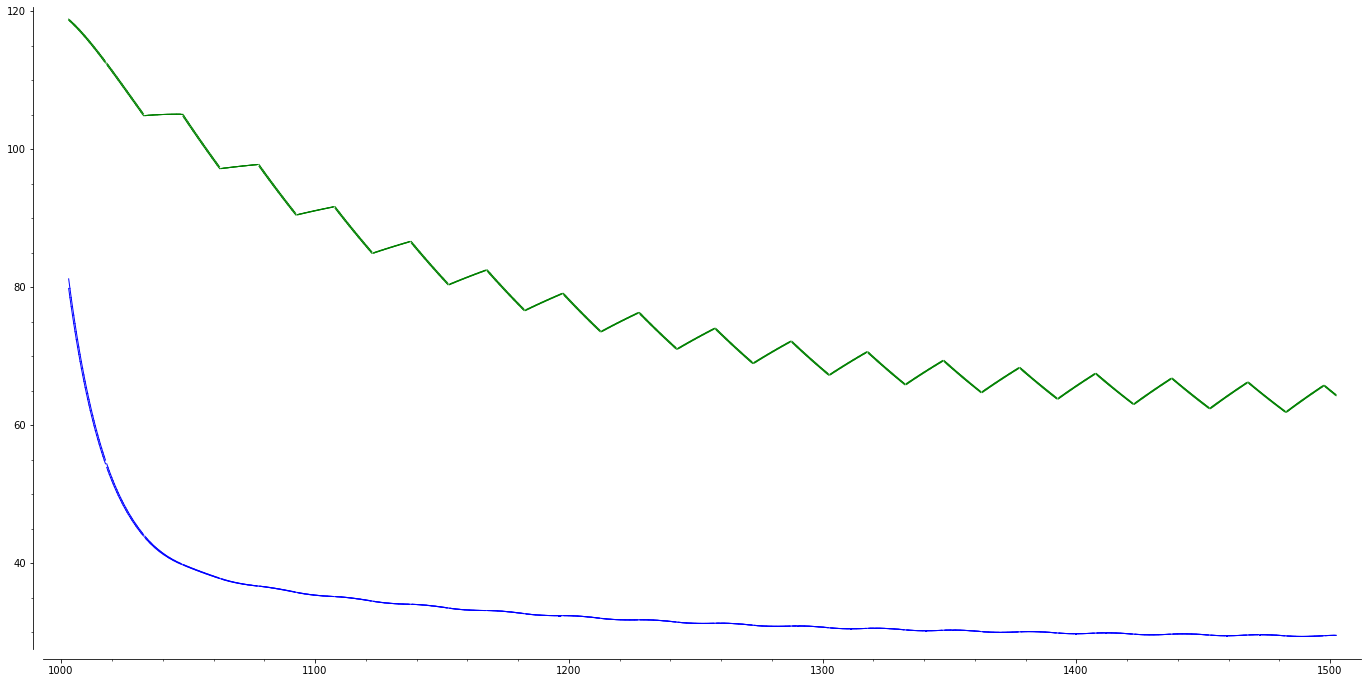

In [18]:
p = verified_trace1.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

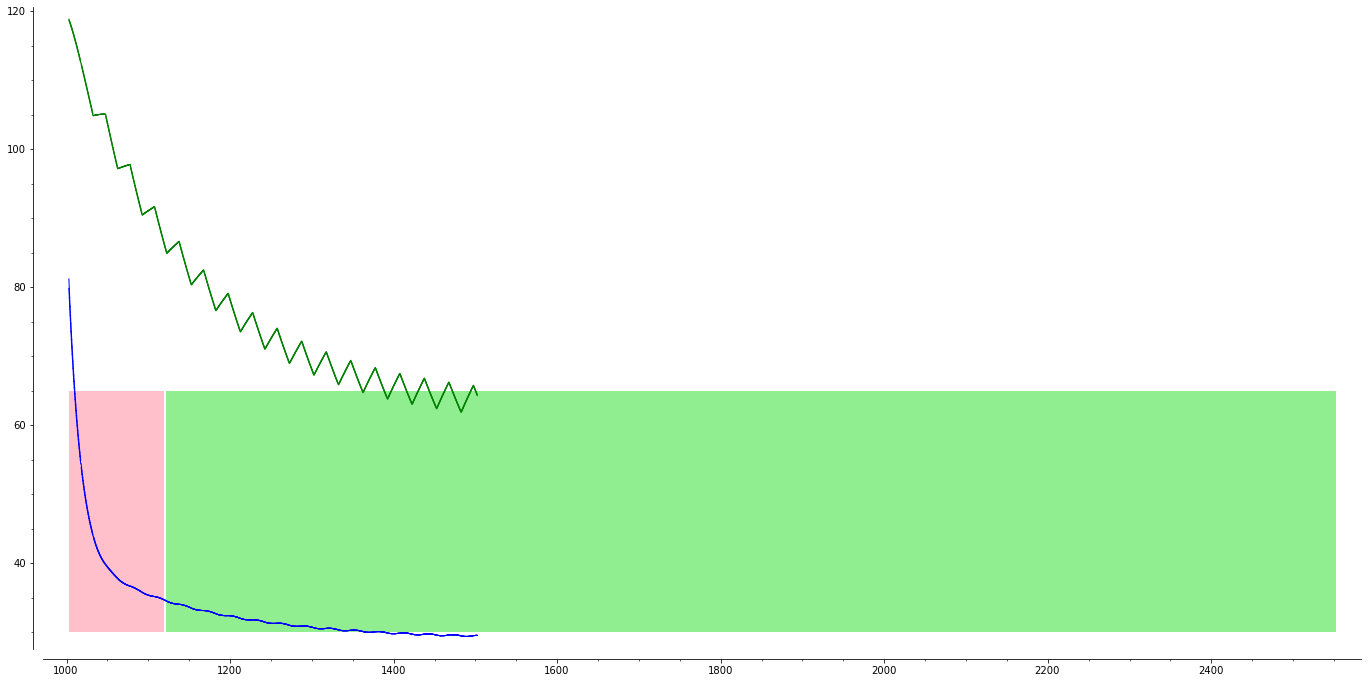

In [19]:
p1 = (verified_sigs1[0].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

/home/sage/sage/local/lib/python3.9/site-packages/sage/plot/contour_plot.py:206: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


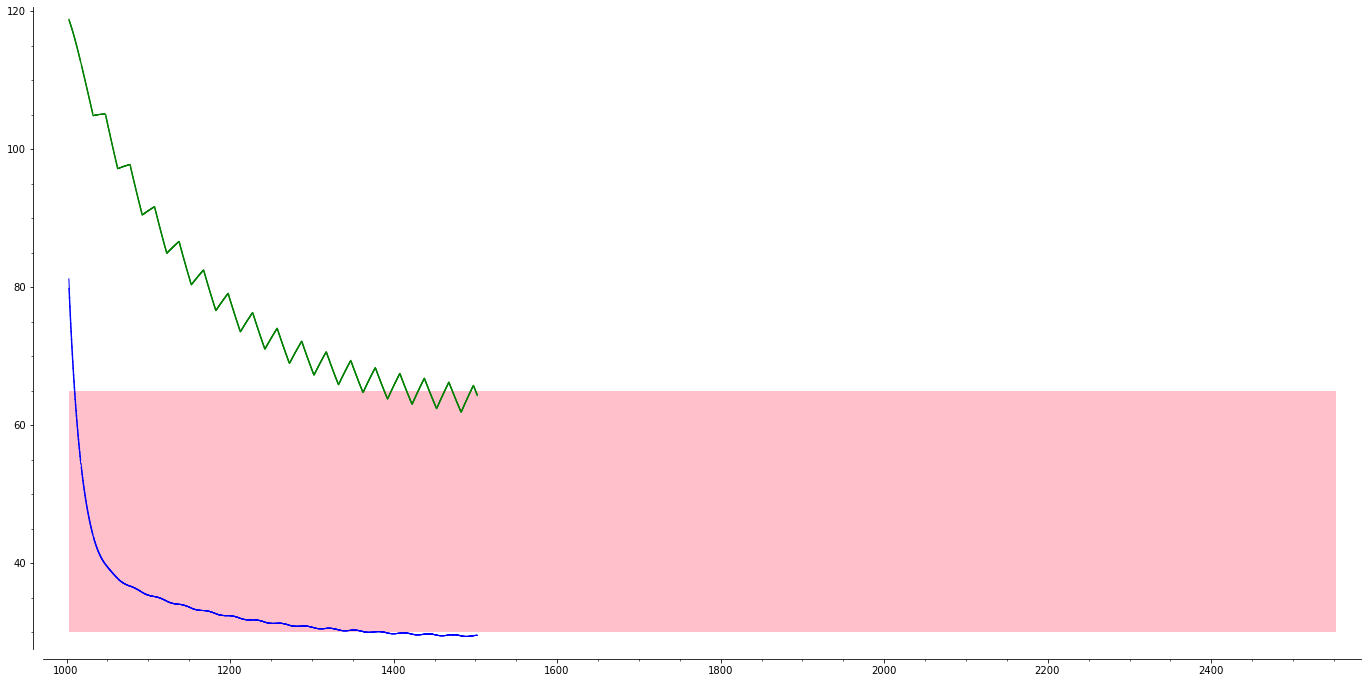

In [20]:
p1 = (verified_sigs1[1].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

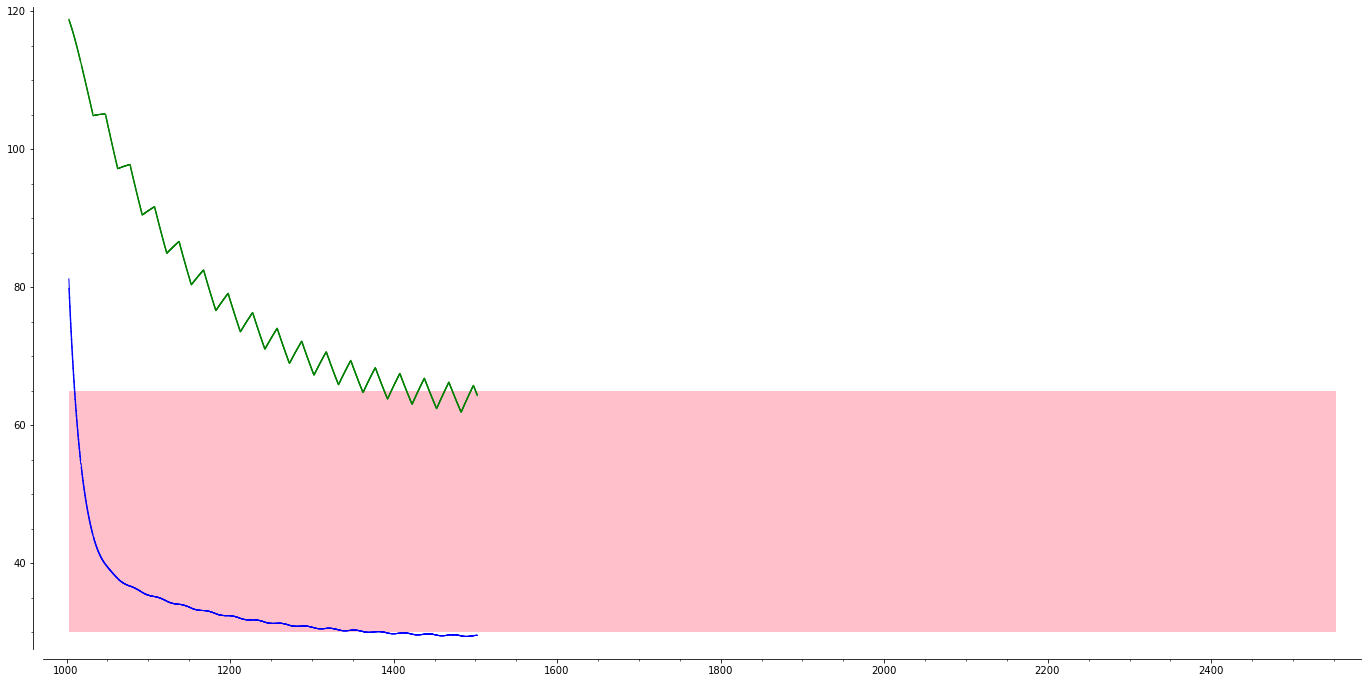

In [21]:
p1 = (verified_sigs1[2].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

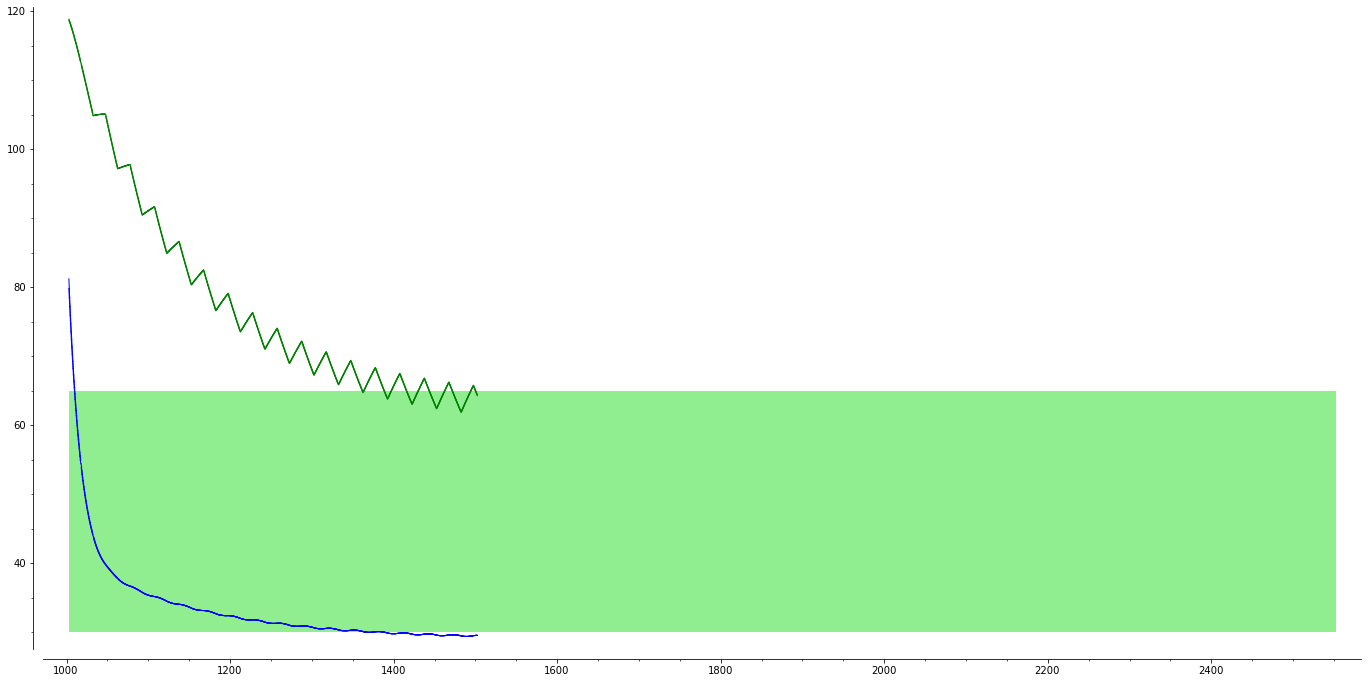

In [22]:
p1 = (verified_sigs1[3].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

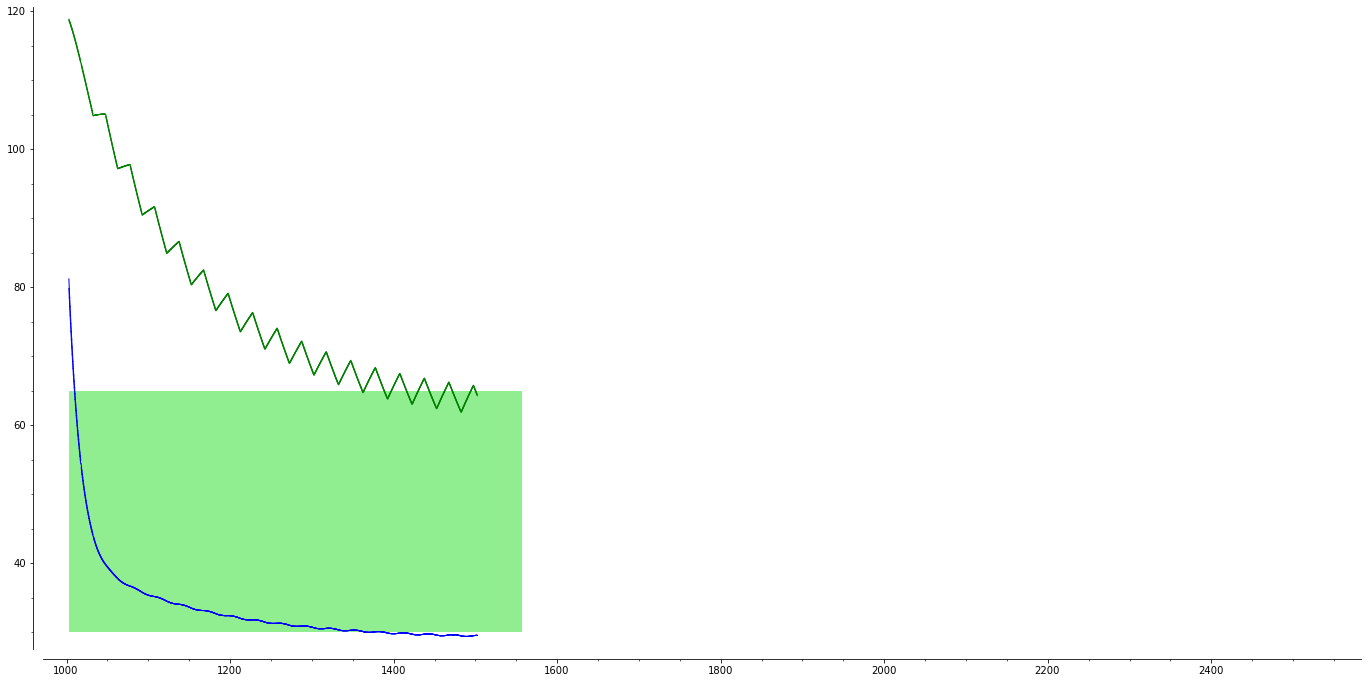

In [23]:
p1 = (verified_sigs1[4].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

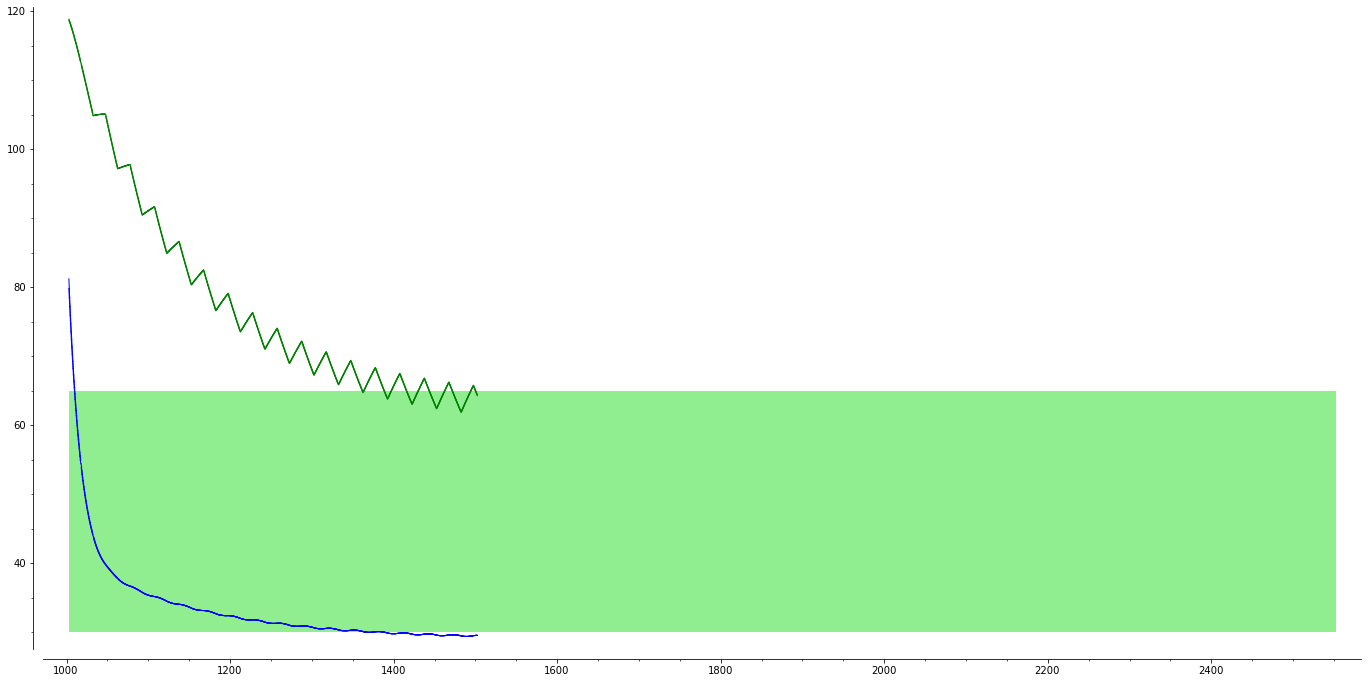

In [24]:
p1 = (verified_sigs1[5].plot(y_range=(30, 65)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

### Anomoly 2

In [25]:
m.self_adaptation_manager.state_machine.anomaly_parameters[1]

(1068.5938409201124,
 1568.5938409201124,
 38.48557931545541,
 103.27713248422768,
 21,
 3.0,
 10,
 5,
 272.01832249938576,
 8.315644265351954,
 227.76228512,
 1.92343277)

In [26]:
verified_trace2, verified_model2 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[1])
verified_sigs2 = m.self_adaptation_manager.state_machine.verified_monitoring_results[1]

x = [1068.5938409201124?, 103.27713248422768, 38.48557931545541]
state = {'heater_on': False, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1083.59384092?, 95.4951270?, 37.2595208?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1098.59384092?, 88.4879117?, 35.9667769?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1113.59384092?, 89.9333420?, 35.045294?]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1128.59384092?, 83.358682?, 34.276165?]
state = {'heater_on': True, 'current_state': <OpenLoopState.HEATING: 2>}
running for [15.000000000000000 .. 15.000000000000000] ...
x = [1143.59384092?, 85.234855?, 33.68754?]
state = {'heater_on': False, 'current_state

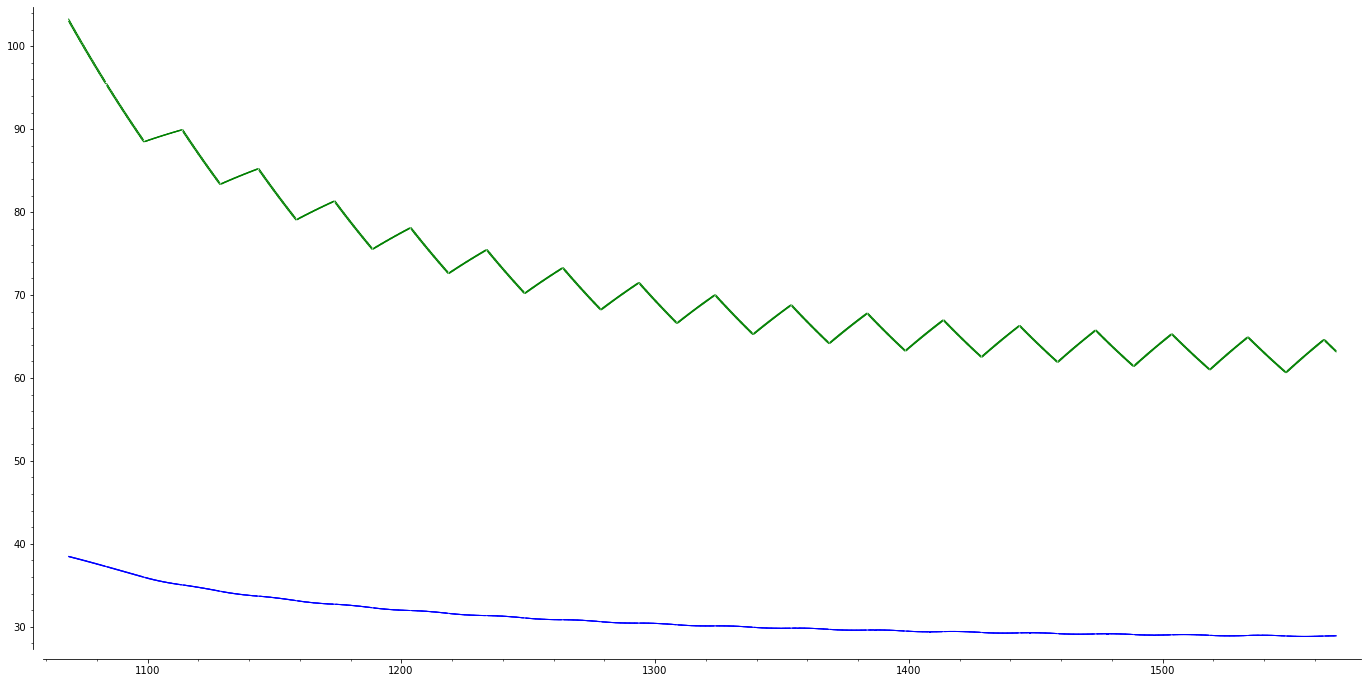

In [27]:
p = verified_trace2.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

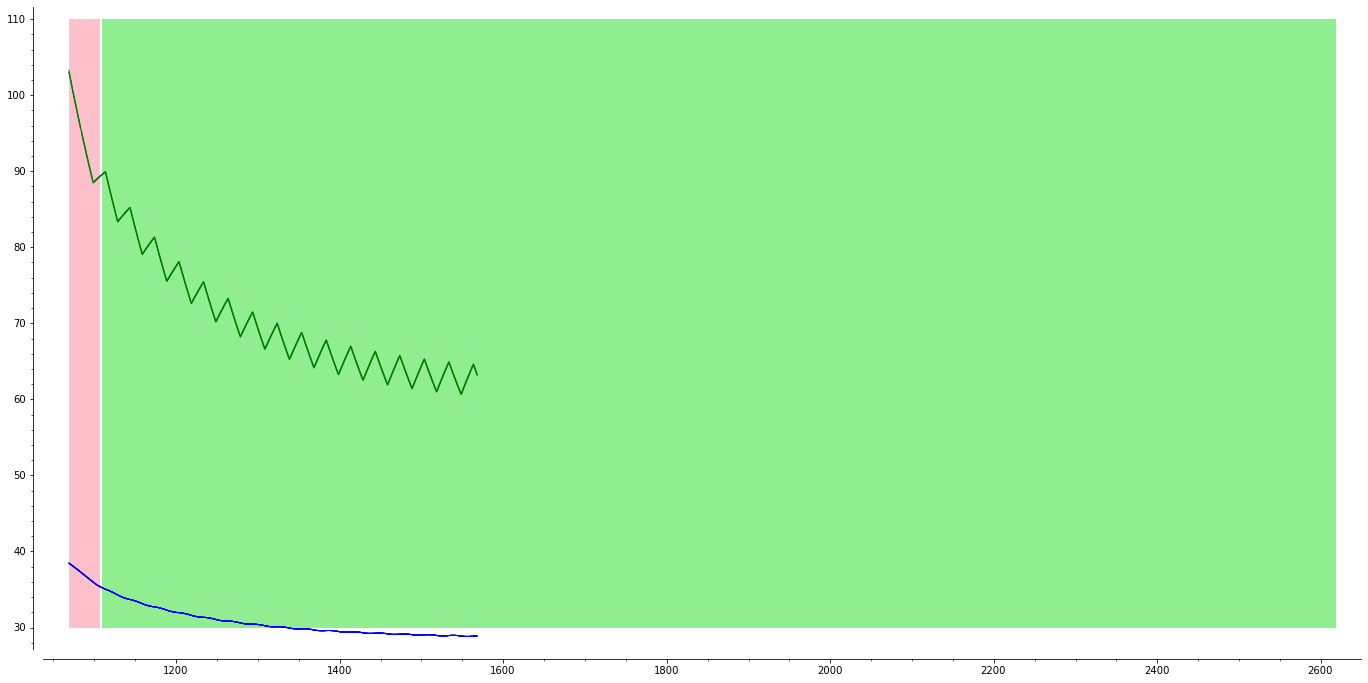

In [28]:
p1 = (verified_sigs2[0].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

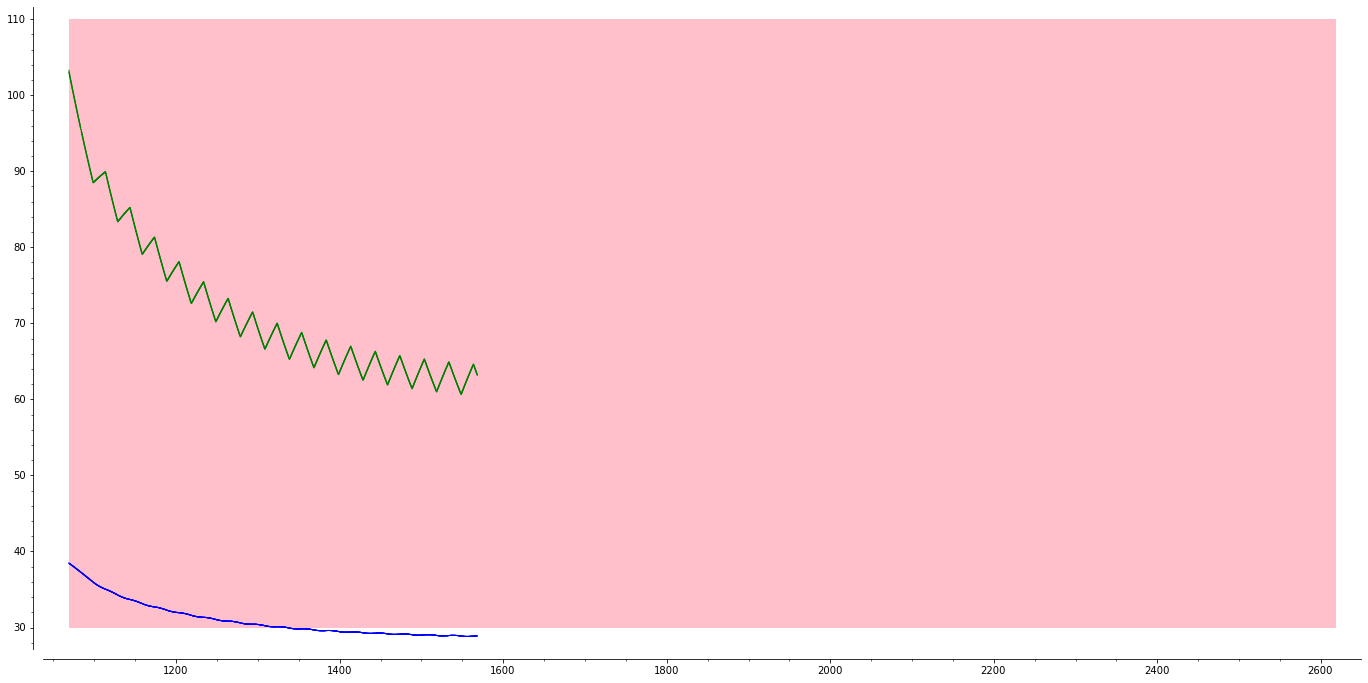

In [29]:
p1 = (verified_sigs2[1].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

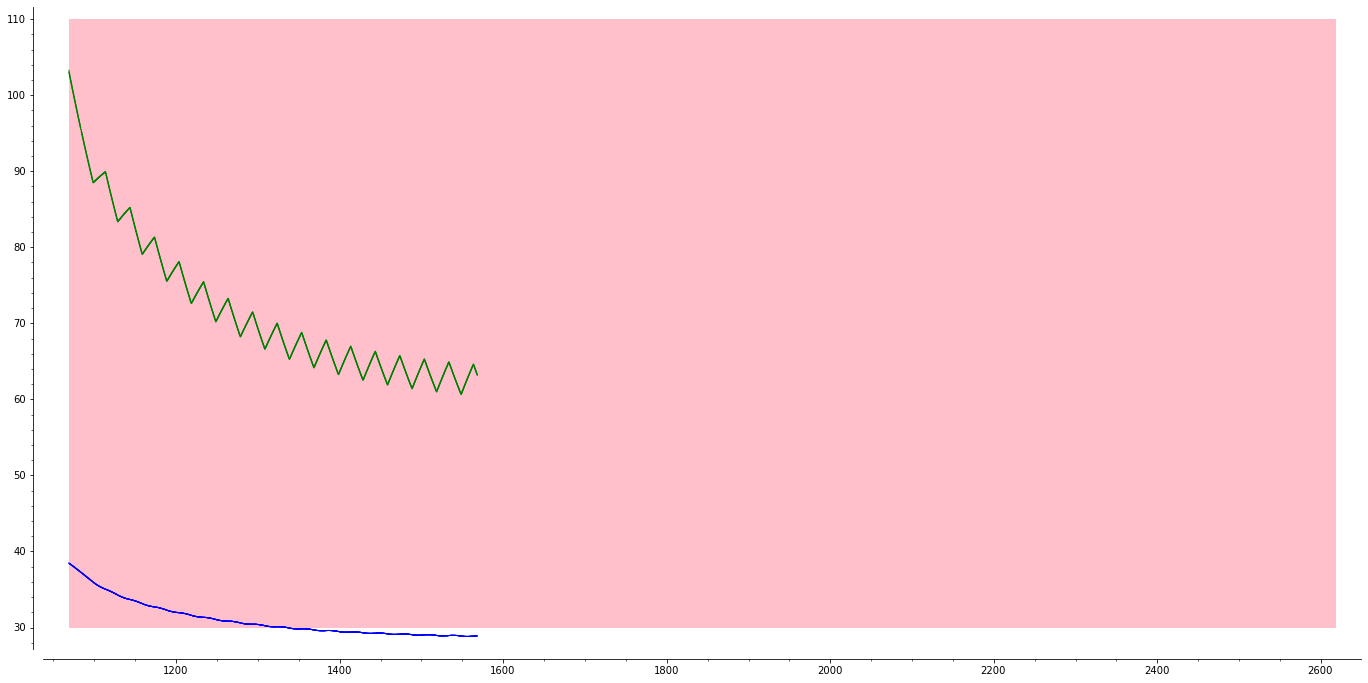

In [30]:
p1 = (verified_sigs2[2].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

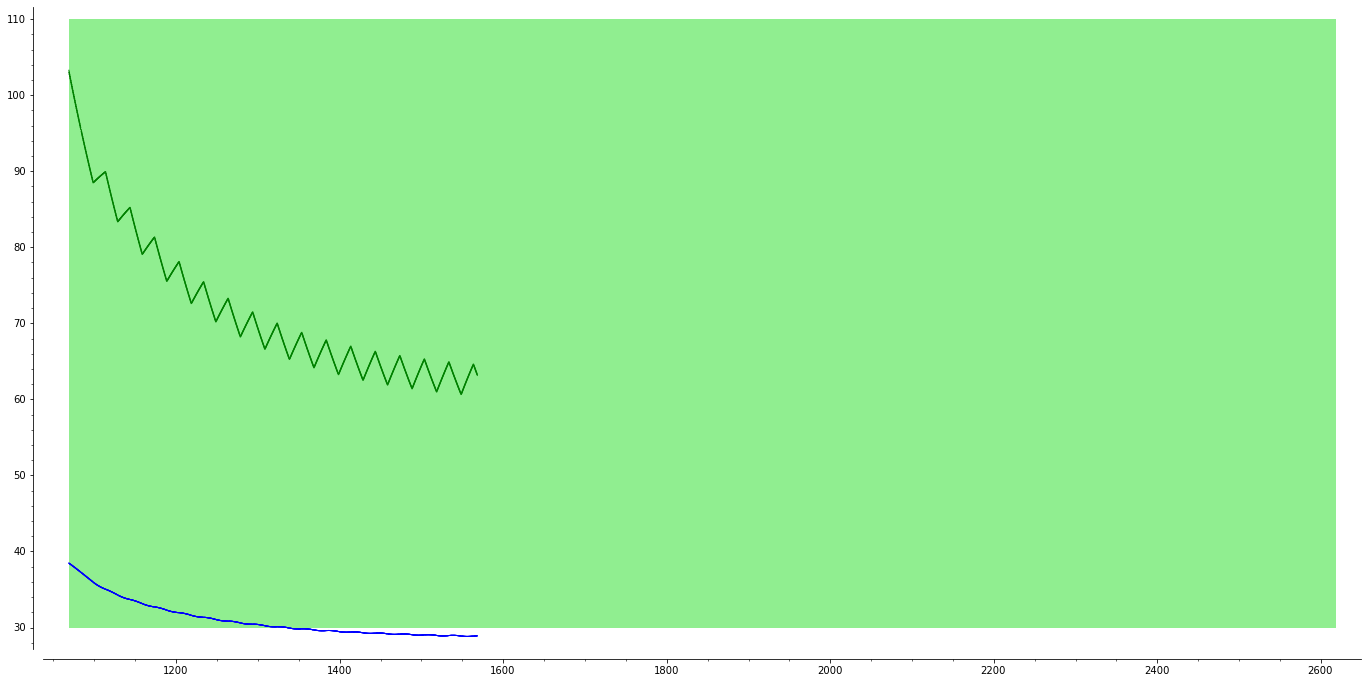

In [31]:
p1 = (verified_sigs2[3].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

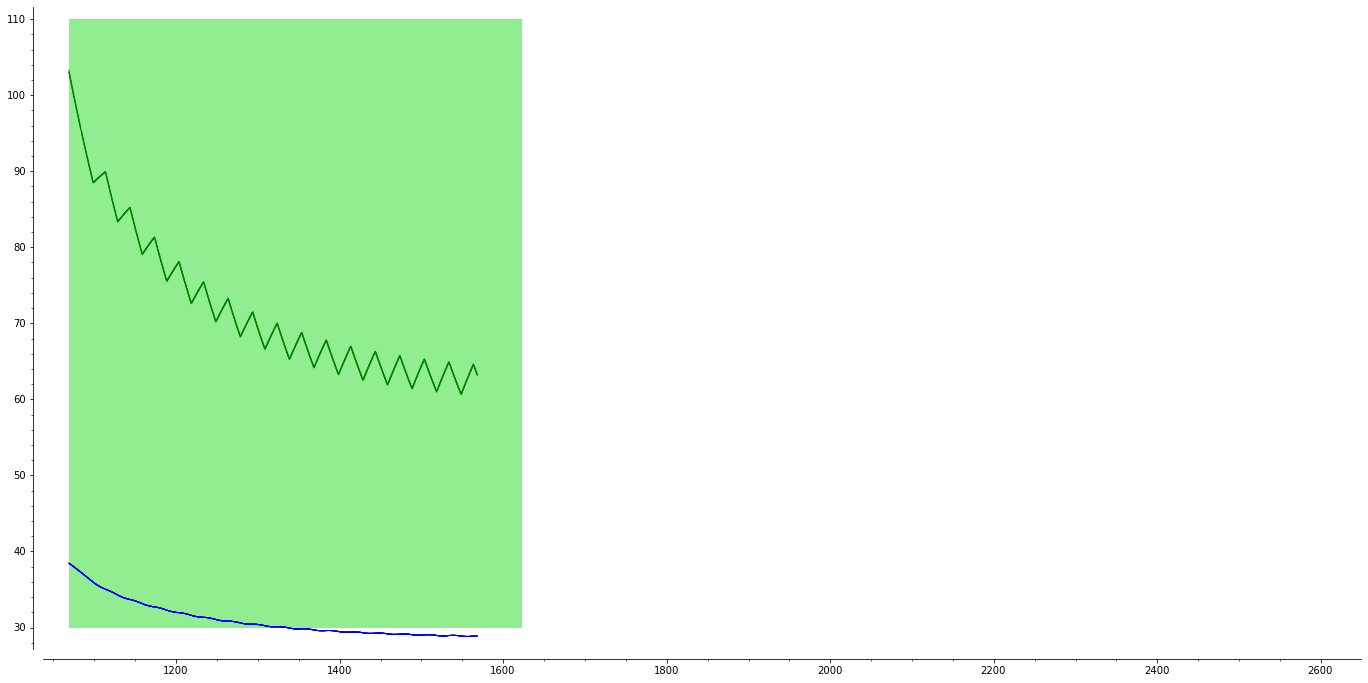

In [32]:
p1 = (verified_sigs2[4].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

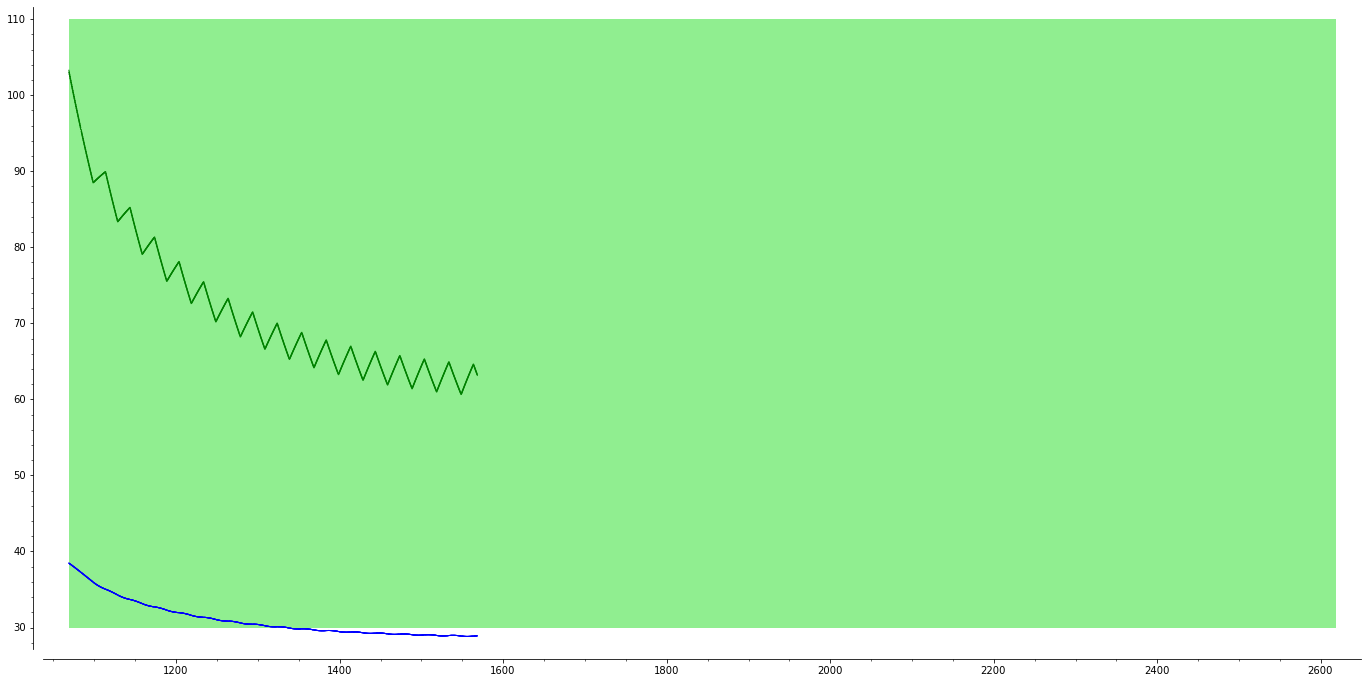

In [33]:
p1 = (verified_sigs2[5].plot(y_range=(30, 110)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

#### Anomoly 3

In [34]:
m.self_adaptation_manager.state_machine.anomaly_parameters[2]

(2010.5938409201124,
 2510.5938409201126,
 32.607154528547476,
 59.77326802388883,
 21,
 3.0,
 10,
 0,
 102.28707795820601,
 1.412942235649828,
 227.76228512,
 1.92343277)

In [35]:
verified_trace3, verified_model3 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[2])
verified_sigs3 = m.self_adaptation_manager.state_machine.verified_monitoring_results[2]

x = [2010.5938409201124?, 59.77326802388883, 32.607154528547476]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [500.00000000000022 .. 500.00000000000023] ...
ran verified simulation in 5.1103479862213135 sec


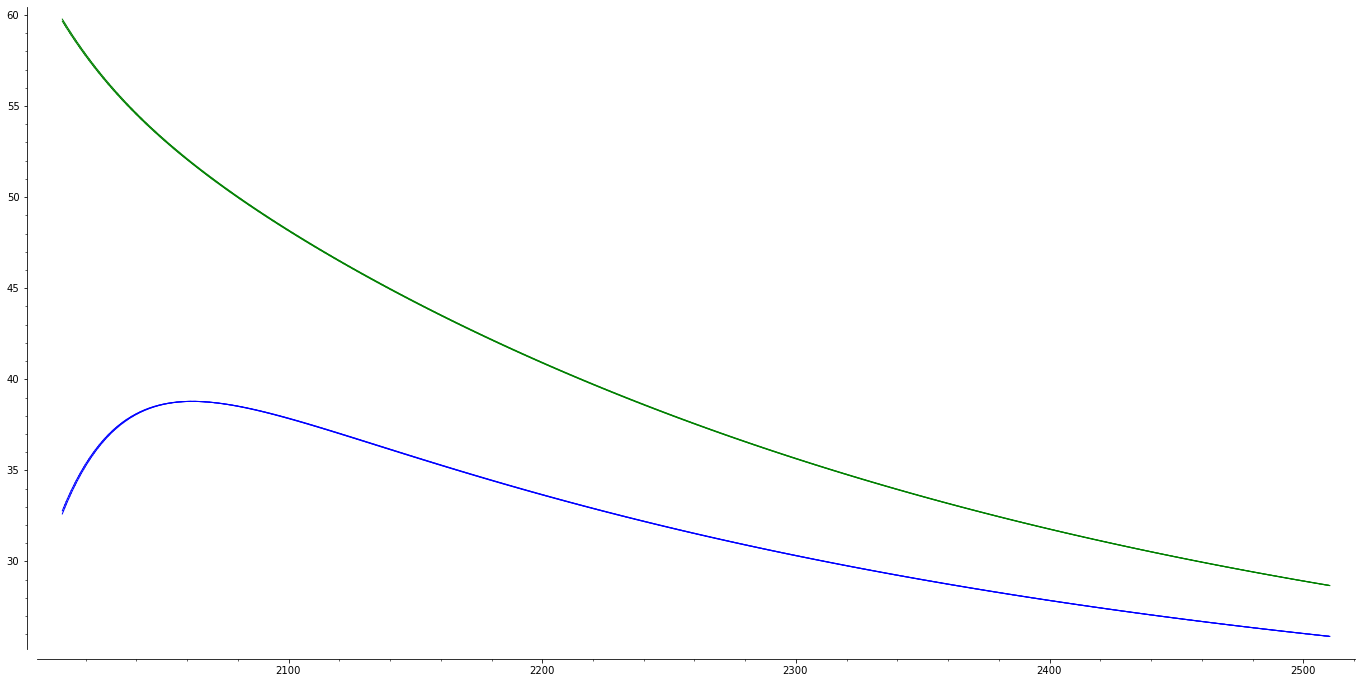

In [36]:
p = verified_trace3.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

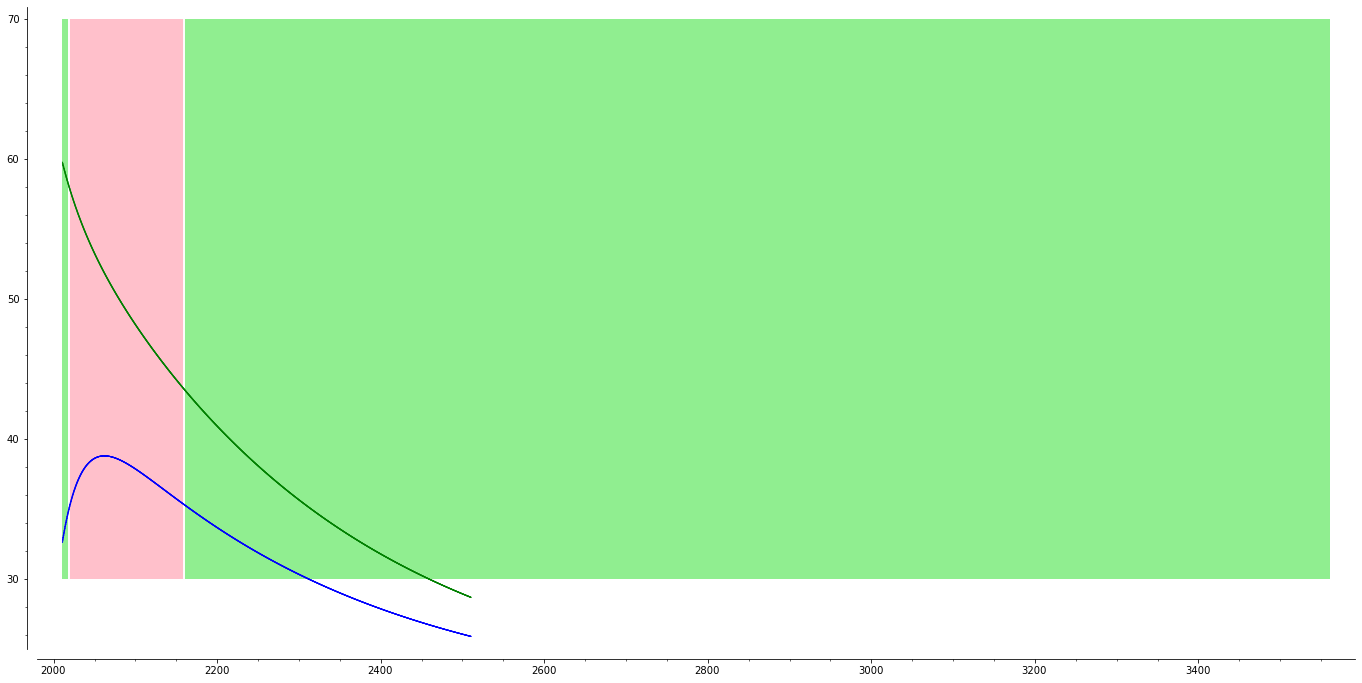

In [37]:
p1 = (verified_sigs3[0].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

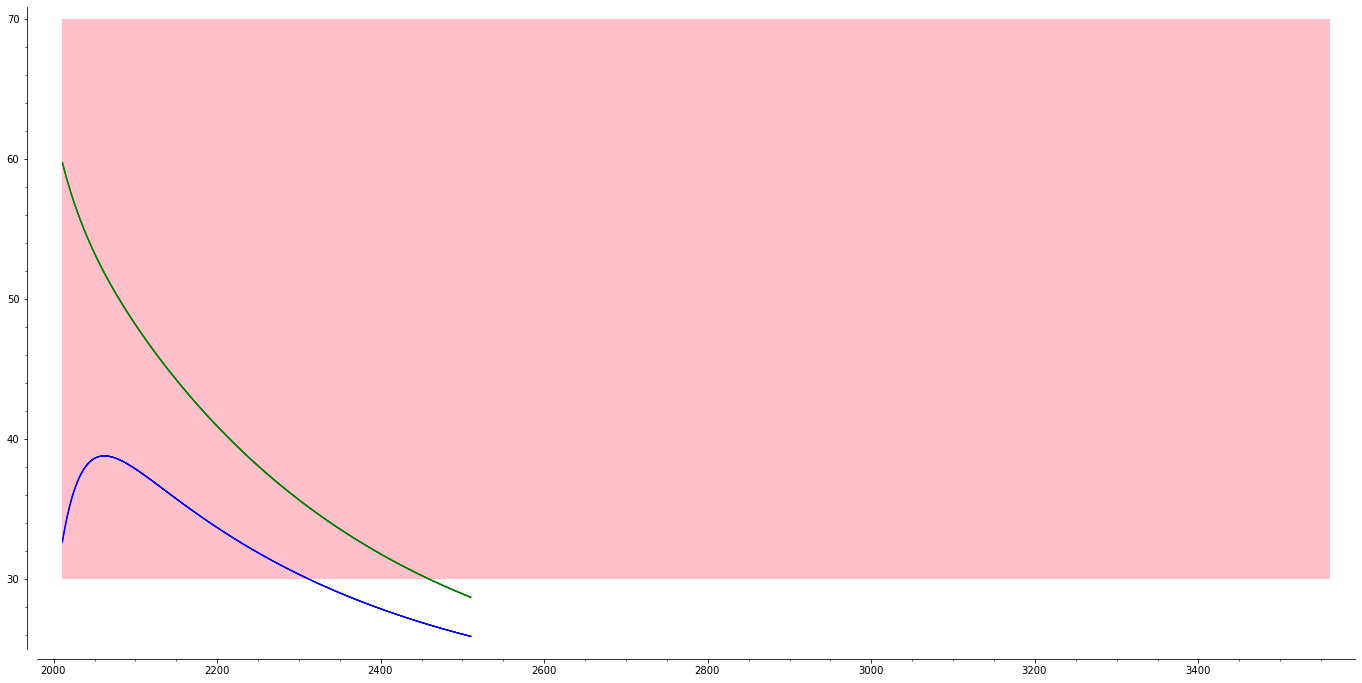

In [38]:
p1 = (verified_sigs3[1].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

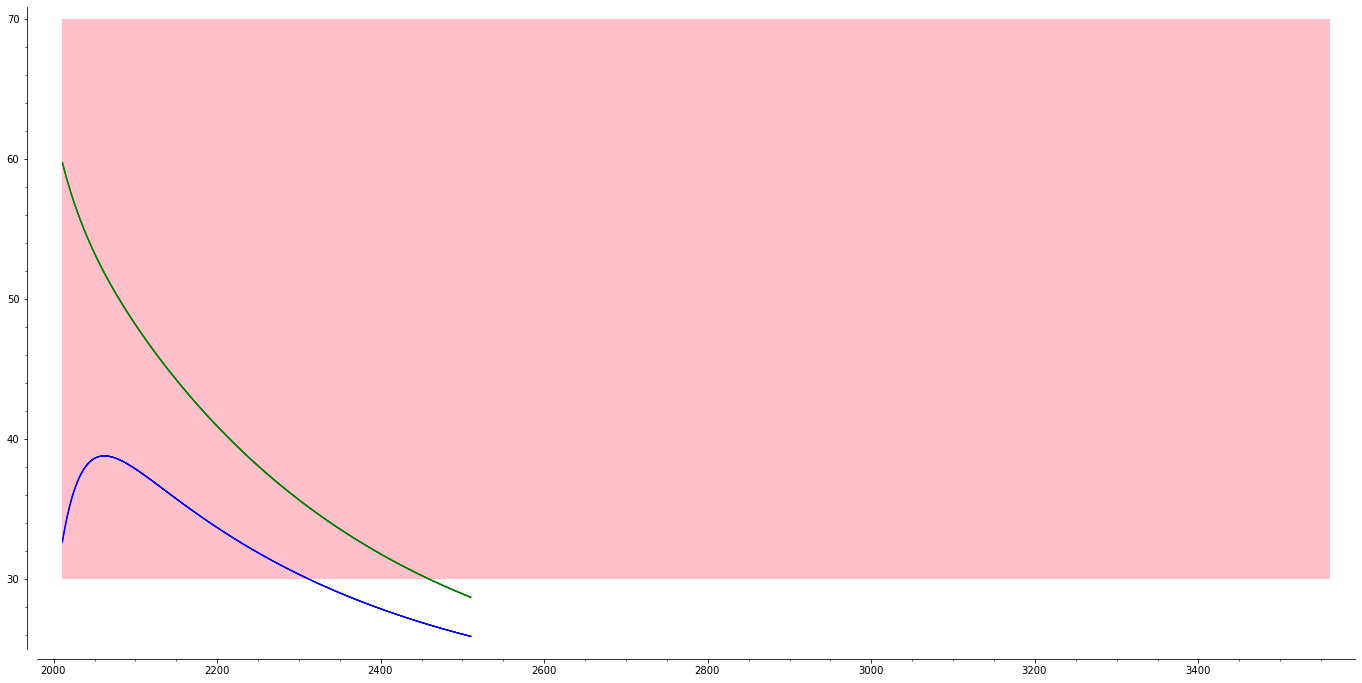

In [39]:
p1 = (verified_sigs3[2].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

In [40]:
tstart, tend = m.self_adaptation_manager.state_machine.anomaly_durations[2]

In [ ]:
 success, C_air, G_box, C_heater, G_heater = calibrator.calibrate(tstart, tend)

In [41]:
m.self_adaptation_manager.state_machine.kalman_filter.update_parameters(C_air, G_box, C_heater, G_heater)

In [42]:
C_air, G_box, C_heater, G_heater

(145.69782402, 0.79154106, 227.76228512, 1.92343277)

In [43]:
signals, t_start_idx, t_end_idx = calibrator.database.get_plant_signals_between(tstart, tend)
times = signals["time"][t_start_idx:t_end_idx]
reference_T = signals["T"][t_start_idx:t_end_idx]
ctrl_signal = signals["in_heater_on"][t_start_idx:t_end_idx]
reference_T_heater = signals["T_heater"][t_start_idx:t_end_idx]
room_T = signals["in_room_temperature"][t_start_idx:t_end_idx]

In [44]:
sol, model = calibrator.plant_simulator.run_simulation(
    times, reference_T[0], reference_T_heater[0], room_T, ctrl_signal,
    C_air, G_box, C_heater, G_heater)

In [45]:
from verified_twin.traces import NumericalContinuousTrace

In [46]:
tr = NumericalContinuousTrace(RIF(tstart, tend), [sol])

In [47]:
sol.y

array([[2010.59384092, 2013.59384092, 2016.59384092, 2019.59384092,
        2022.59384092, 2025.59384092, 2028.59384092, 2031.59384092,
        2034.59384092, 2037.59384092, 2040.59384092],
       [  32.60715453,   33.45621261,   34.27189811,   35.08150627,
          35.88518709,   36.68308434,   37.47556355,   38.22415444,
          38.90750242,   39.5304303 ,   40.09740534],
       [  59.77326802,   59.25985223,   60.25201607,   61.24324098,
          62.22984772,   63.21180535,   64.02036038,   63.36918223,
          62.74885584,   62.16037422,   61.60148605]])

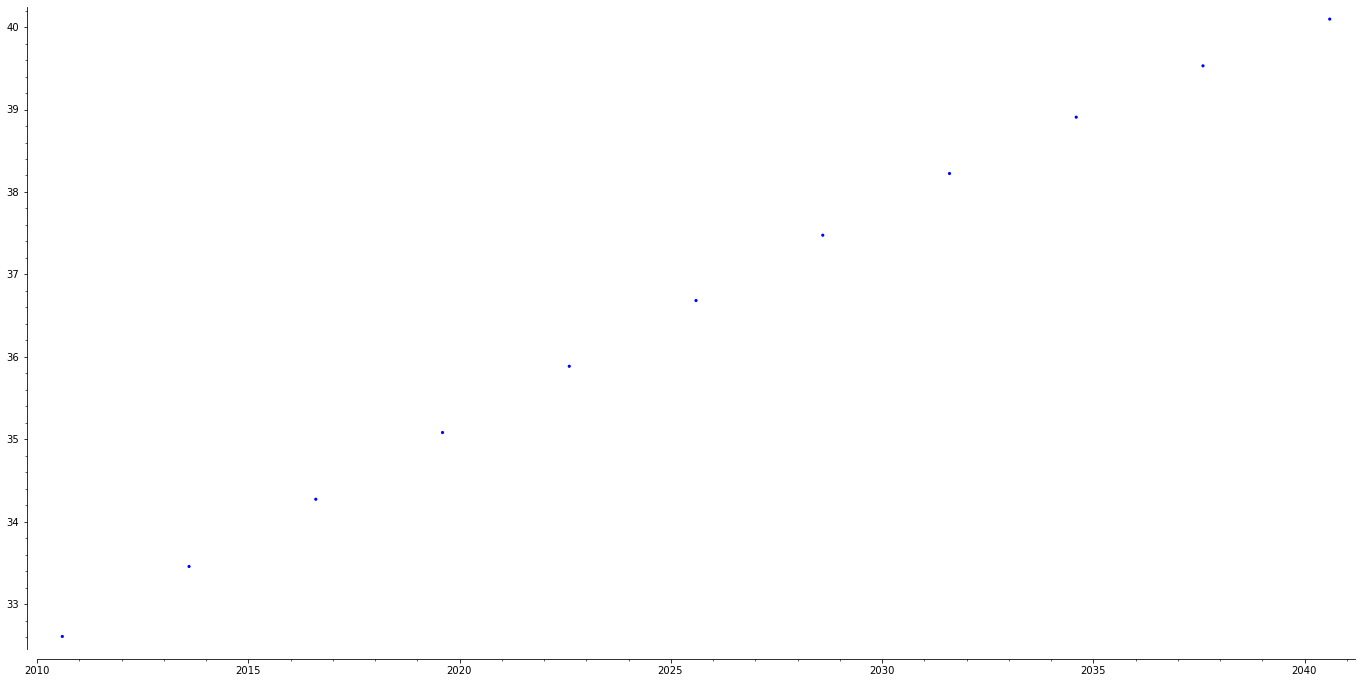

In [48]:
sg.points(zip(sol.y[0], sol.y[1])).matplotlib()

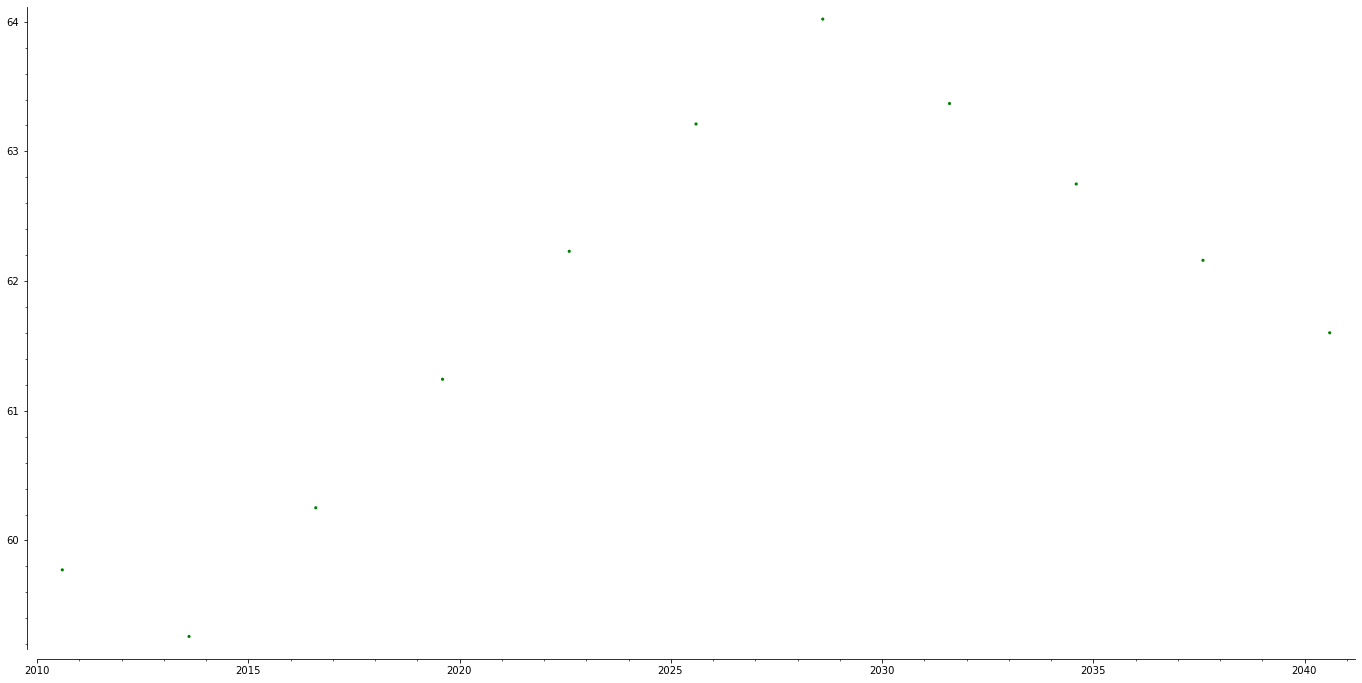

In [49]:
sg.points(zip(sol.y[0], sol.y[2]), color='green').matplotlib()

In [50]:
verified_trace3b, verified_model3b = VerifiedPlantMonitor4Params.run_simulation(tstart, tend, *m.self_adaptation_manager.state_machine.anomaly_parameters[2][2:])

x = [2010.5938409201124?, 59.77326802388883, 32.607154528547476]
state = {'heater_on': False, 'current_state': <OpenLoopState.COOLING: 3>}
running for [33.000000000000000 .. 33.000000000000000] ...
ran verified simulation in 0.31577420234680176 sec


In [51]:
from verified_twin.incubator_models import SwitchingFourParameterModel
from verified_twin.controllers import SignalArraySwitchedController
from verified_twin.simulators import HybridSimulator
from verified_twin.parametric_models import SwitchingParametricModel, IntervalParametricModel

In [52]:
from verified_twin.incubator_models import *


In [53]:
class SwitchingFourParameterModelCAGB(SwitchingParametricModel):
    def __init__(self, x0, **params):
        default_params = {
            "C_H": RIF("243.45802367"),
            # "C_A": RIF("68.20829072"),
            "V":   RIF("12.00"),
            "I":   RIF("10.45"),
            "T_R": RIF("21.25"),
            "G_H": RIF("0.87095429"),
            # "G_B": RIF("0.73572788"),
        }
        params_RIF = {
            k: RIF(v)
            for k,v in params.items()
        }
        default_params.update(params_RIF)
        super().__init__(x0, **default_params)

    def model_fn(self, x, state):
        print(f"regenerating model with x={[xi.str(style='brackets') for xi in x]}")
        return IntervalParametricModel(
            "t,T_H,T_A,C_A,G_B",
            x,
            [
                RIF(1),
                (RIF(1)/C_H)*(int(state['heater_on'])*V*I - G_H*(T_H - T_A)),
                (RIF(1)/C_A)*(G_H*(T_H - T_A) - G_B*(T_A - T_R)),
                RIF(0), # C_A
                RIF(0), # G_B
            ],
            self.params,
            nonpoly=True,
            vars=(t,T_H,T_A,C_A,G_B),
        )

In [188]:
default_variable_spread = 2**-2

In [262]:
def verified_trace(T_H_spread, T_A_spread, C_air_spread, G_box_spread):
    model = SwitchingFourParameterModelCAGB(
        [RIF(tstart),
        RIF(m.self_adaptation_manager.state_machine.anomaly_parameters[2][3]) + RIF(-T_H_spread,T_H_spread),
        RIF(m.self_adaptation_manager.state_machine.anomaly_parameters[2][2]) + RIF(-T_A_spread,T_A_spread),
        RIF(C_air) + RIF(-C_air_spread, C_air_spread),
        RIF(G_box) + RIF(-G_box_spread, G_box_spread)],
        T_R=room_T[0],
        C_H=C_heater, G_H=G_heater)
    controller = SignalArraySwitchedController(
        {'heater_on': False},
        times,
        {'heater_on': ctrl_signal},
    )
    simulator = HybridSimulator(model, controller,
        controller_input_map=(lambda x: x[0]),
        controller_output_map=(lambda xin, x: xin),
    )
    return simulator.run(start_time=RIF(tstart), time_limit=(RIF(tend) - RIF(tstart)))

In [263]:
verified_trace3c = verified_trace(2**-2, 2**-2, 2**-2, 2**-2)

x = [2010.5938409201124?, 60.?, 33.?, 146.?, 1.?]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[59.523268023888824 .. 60.023268023888840]', '[32.357154528547468 .. 32.857154528547483]', '[145.44782401999998 .. 145.94782402000005]', '[0.54154105999999990 .. 1.0415410600000002]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 59.?, 34.?, 146.?, 1.?]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.853700193756786 .. 59.355277129274996]', '[33.147007549360544 .. 33.765848668468330]', '[145.44782401999992 .. 145.94782402000010]', '[0.54154105999996660 .. 1.0415410600000335]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 64.?, 4.?e1, 146.?, 1.?]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[63.777205070990980 .. 64.330483712142908]', '[36.82720129656615

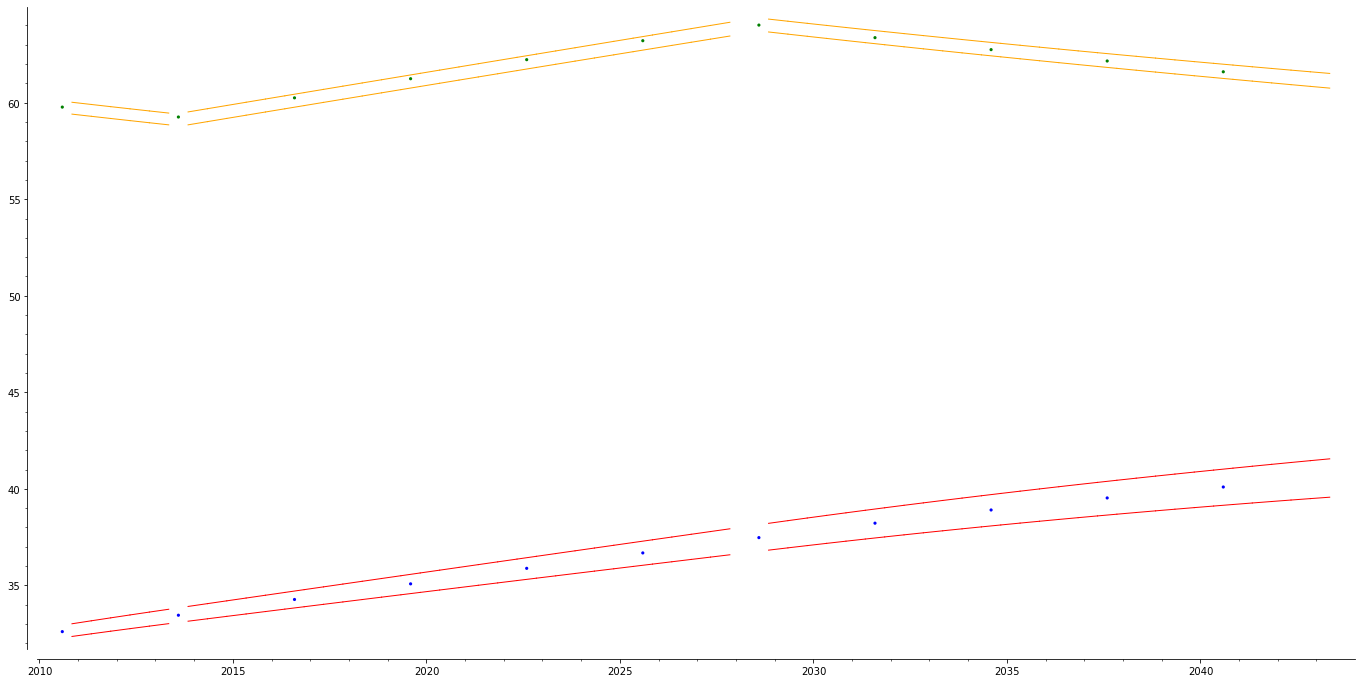

In [264]:
(  sg.points(zip(sol.y[0], sol.y[1]))
 + sg.points(zip(sol.y[0], sol.y[2]), color='green')
 + verified_trace3c.plot(('T_A', 'T_H'), color=('red', 'orange'))
).matplotlib()

In [265]:
verified_trace3d = verified_trace(-2**1, -2**1, 2**-1, 2**-1)

x = [2010.5938409201124?, 6.?e1, 4.?e1, 146.?, 1.?]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[57.773268023888832 .. 61.773268023888833]', '[30.607154528547475 .. 34.607154528547476]', '[145.19782401999998 .. 146.19782402000005]', '[0.29154105999999990 .. 1.2915410600000002]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 146.?, 1.?]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[57.102719960012294 .. 61.106257501624520]', '[31.342162006058440 .. 35.570705026347924]', '[145.19782401999989 .. 146.19782402000013]', '[0.29154105999993329 .. 1.2915410600000668]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 146.?, 1.?]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.001663048887479 .. 66.106030053065908]', '[34.721006335

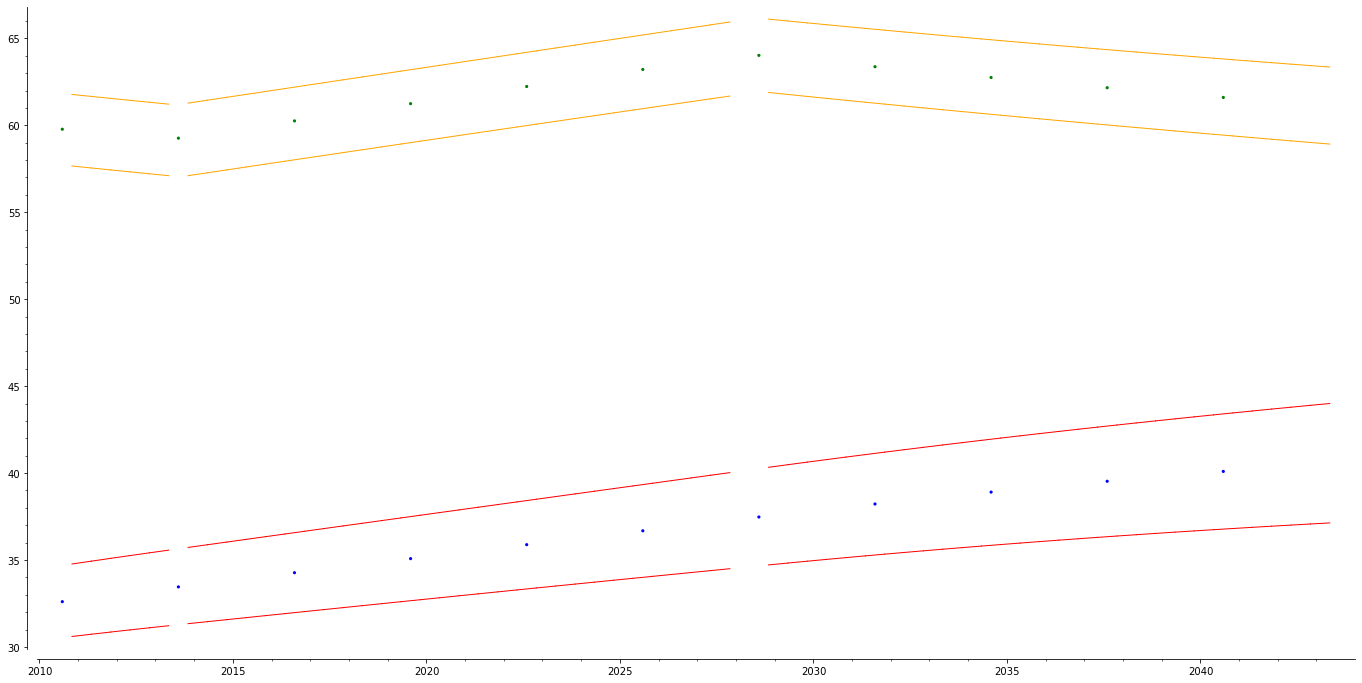

In [266]:
(  sg.points(zip(sol.y[0], sol.y[1]))
 + sg.points(zip(sol.y[0], sol.y[2]), color='green')
 + verified_trace3d.plot(('T_A', 'T_H'), color=('red', 'orange'))
).matplotlib()

In [267]:
def euclidian_norm(xs):
    return sum(x**2 for x in xs)

In [268]:
euclidian_norm([RIF(-2**1, 2**1), RIF(-2**1, 2**1)])

1.?e1

In [269]:
euclidian_norm([RIF(-2**2, 2**2), RIF(-2**2, 2**2)])

1.?e2

In [270]:
durations = [RIF(t1, t2) for t1, t2 in zip(times, times[1:])]

In [271]:
[d.str(style='brackets') for d in durations]

['[2010.5938409201123 .. 2013.5938409201124]',
 '[2013.5938409201123 .. 2016.5938409201124]',
 '[2016.5938409201123 .. 2019.5938409201124]',
 '[2019.5938409201123 .. 2022.5938409201124]',
 '[2022.5938409201123 .. 2025.5938409201124]',
 '[2025.5938409201123 .. 2028.5938409201124]',
 '[2028.5938409201123 .. 2031.5938409201124]',
 '[2031.5938409201123 .. 2034.5938409201124]',
 '[2034.5938409201123 .. 2037.5938409201124]',
 '[2037.5938409201123 .. 2040.5938409201124]']

In [272]:
sol.y

array([[2010.59384092, 2013.59384092, 2016.59384092, 2019.59384092,
        2022.59384092, 2025.59384092, 2028.59384092, 2031.59384092,
        2034.59384092, 2037.59384092, 2040.59384092],
       [  32.60715453,   33.45621261,   34.27189811,   35.08150627,
          35.88518709,   36.68308434,   37.47556355,   38.22415444,
          38.90750242,   39.5304303 ,   40.09740534],
       [  59.77326802,   59.25985223,   60.25201607,   61.24324098,
          62.22984772,   63.21180535,   64.02036038,   63.36918223,
          62.74885584,   62.16037422,   61.60148605]])

In [273]:
for d, y1, y2 in zip(durations, *sol.y[1:]):
    print(f"y = {(y1, y2)}, d = {d.str(style='brackets')}")

y = (32.607154528547476, 59.77326802388883), d = [2010.5938409201123 .. 2013.5938409201124]
y = (33.45621261462899, 59.25985222602985), d = [2013.5938409201123 .. 2016.5938409201124]
y = (34.271898112273476, 60.2520160710407), d = [2016.5938409201123 .. 2019.5938409201124]
y = (35.081506269046365, 61.2432409849257), d = [2019.5938409201123 .. 2022.5938409201124]
y = (35.88518708936779, 62.2298477184906), d = [2022.5938409201123 .. 2025.5938409201124]
y = (36.68308433856493, 63.21180534637118), d = [2025.5938409201123 .. 2028.5938409201124]
y = (37.47556354891441, 64.02036038110876), d = [2028.5938409201123 .. 2031.5938409201124]
y = (38.22415444480015, 63.369182230640135), d = [2031.5938409201123 .. 2034.5938409201124]
y = (38.90750241733678, 62.74885584172137), d = [2034.5938409201123 .. 2037.5938409201124]
y = (39.53043029517221, 62.16037422349636), d = [2037.5938409201123 .. 2040.5938409201124]


In [274]:
def violation_degree(sol, trace):
    times = sol.y[0]
    durations = [RIF(t1) for t1 in times]
    intervals = [eval_trace(trace.continuous_part, duration) for duration in durations]
    #print(f"intervals = {[(i.str(style='brackets') if i else None) for i in intervals]}")
    return sum(
        euclidian_norm(inner_dist_from_int(y, interval[i])
            for y, interval in zip(ys, intervals))
        for i, ys in enumerate(reversed(sol.y[1:]), 1)
    ).lower()

In [275]:
def inner_dist_from_int(x, I):
    print(f"computing inner dist of {x} and {I.str(style='brackets')}")
    if x > I.upper():
        return (RIF(x) - I)
    elif x < I.lower():
        return (I - RIF(x))
    else:
        return RIF(0)

In [276]:
inner_dist_from_int(1.1, RIF(-1, 1)).lower()

computing inner dist of 1.1 and [-1.0000000000000000 .. 1.0000000000000000]


0.100000000000000

In [277]:
from lbuc.interval_utils import int_dist

In [278]:
durations[0].str(style='brackets')

'[2010.5938409201123 .. 2013.5938409201124]'

In [279]:
verified_trace3c.continuous_part.values[0](durations[0] - durations[0].edges()[0])

[2.02?e3, 6.?e1, 33.?, 146.?, 1.?]

In [280]:
verified_trace3c.domain.str(style='brackets')

'[2010.5938409201123 .. 2043.5938409201124]'

In [281]:
def eval_trace(tr, t):
    y = None
    t0 = tr.domain.edges()[0]
    
    for r in tr.values:
        print(f"t0 = {t0.str(style='brackets')}, t = {t.str(style='brackets')}, r.time = {r.time}")
        if t.overlaps(t0 + RIF(0, r.time)):
            print("overlap!")
            y = tr.interval_list_union(r(t - t0), y)
            print(f"y = {[yi.str(style='brackets') for yi in y]}")
        t0 += RIF(r.time)

    return y

In [282]:
eval_trace(verified_trace3c.continuous_part, durations[0])

t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2010.5938409201123 .. 2013.5938409201124], r.time = 3.0
overlap!
y = ['[2010.5938409201123 .. 2013.5938409203473]', '[58.853699987854369 .. 60.023268051839893]', '[32.357149636450508 .. 33.765849063959309]', '[145.44782401999992 .. 145.94782402000010]', '[0.54154105999996660 .. 1.0415410600000335]']
t0 = [2013.5938409201123 .. 2013.5938409201124], t = [2010.5938409201123 .. 2013.5938409201124], r.time = 14.99999999996885
overlap!
y = ['[2010.5938409201123 .. 2013.5938409203473]', '[58.853699987854369 .. 60.023268051839893]', '[32.357149636450508 .. 33.765854635469467]', '[145.44782401999989 .. 145.94782402000013]', '[0.54154105999996648 .. 1.0415410600000337]']
t0 = [2028.5938409200812 .. 2028.5938409200813], t = [2010.5938409201123 .. 2013.5938409201124], r.time = 15.00000000003115


[2.02?e3, 6.?e1, 33.?, 146.?, 1.?]

In [283]:
violation_degree(sol, verified_trace3c)

t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 3.0
overlap!
y = ['[2010.5938409201123 .. 2010.5938409201124]', '[59.523267995883827 .. 60.023268051839893]', '[32.357149636450508 .. 32.857159430331152]', '[145.44782401999995 .. 145.94782402000007]', '[0.54154105999999979 .. 1.0415410600000004]']
t0 = [2013.5938409201123 .. 2013.5938409201124], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 14.99999999996885
t0 = [2028.5938409200812 .. 2028.5938409200813], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 15.00000000003115
t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2013.5938409201119 .. 2013.5938409201120], r.time = 3.0
overlap!
y = ['[2013.5938409199393 .. 2013.5938409203468]', '[58.853700193756893 .. 59.355277129275088]', '[33.147007549360431 .. 33.765848668468195]', '[145.44782401999992 .. 145.94782402000010]', '[0.54154105999996660 .. 1.0415410600000335]']
t0 = [2013.5938409201123 .. 2013.593840920

0.000000000000000

In [284]:
violation_degree(sol, verified_trace3d)

t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 3.0
overlap!
y = ['[2010.5938409201123 .. 2010.5938409201124]', '[57.773267900882061 .. 61.773268146844857]', '[30.607081707919807 .. 34.607227396775216]', '[145.19782401999995 .. 146.19782402000007]', '[0.29154105999999968 .. 1.2915410600000004]']
t0 = [2013.5938409201123 .. 2013.5938409201124], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 14.99999999996885
t0 = [2028.5938409200812 .. 2028.5938409200813], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 15.00000000003115
t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2013.5938409201119 .. 2013.5938409201120], r.time = 3.0
overlap!
y = ['[2013.5938409199393 .. 2013.5938409203468]', '[57.102719960012407 .. 61.106257501624605]', '[31.342162006058362 .. 35.570705026347753]', '[145.19782401999989 .. 146.19782402000013]', '[0.29154105999993329 .. 1.2915410600000668]']
t0 = [2013.5938409201123 .. 2013.593840920

0.000000000000000

In [285]:
def cost(p):
    trace = verified_trace(*p)
    
    return (2**5*violation_degree(sol, trace)
          + euclidian_norm(trace(trace.domain.edges()[1])[1:3]).upper())

In [286]:
from scipy.optimize import minimize

In [306]:
opt_res = minimize(cost, np.array([1, 1, 1, 1]), method='Nelder-Mead',
    options={'maxiter': 20, 'xatol': 0.1, 'fatol': 1})

x = [2010.5938409201124?, 6.?e1, 4.?e1, 1.5?e2, 0.?e1]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[58.773268023888832 .. 60.773268023888833]', '[31.607154528547475 .. 33.607154528547476]', '[144.69782402000001 .. 146.69782402000002]', '[-0.20845893999999999 .. 1.7915410600000002]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 1.5?e2, 0.?e1]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.101102936209585 .. 60.107875070127165]', '[32.199819915277750 .. 34.713089724998803]', '[144.69782402000001 .. 146.69782402000002]', '[-0.20845893999999988 .. 1.7915410600000002]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 1.5?e2, 0.?e1]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.936955269913553 .. 65.170755293262744]', '[3

In [307]:
opt_res.success

False

In [308]:
opt_res.x

array([ 1.06809775,  1.36635275,  1.18537228, -0.03477579])

In [309]:
verified_trace3e = verified_trace(*opt_res.x)

x = [2010.5938409201124?, 6.?e1, 4.?e1, 1.5?e2, 0.8?]
state = {'heater_on': False}
regenerating model with x=['[2010.5938409201123 .. 2010.5938409201124]', '[58.705170271230187 .. 60.841365776547477]', '[31.240801779164407 .. 33.973507277930545]', '[144.51245174176602 .. 146.88319629823400]', '[0.75676527054541598 .. 0.82631684945458406]']
running for [3.0000000000000000 .. 3.0000000000000000] ...
x = [2013.593840920?, 6.?e1, 4.?e1, 1.5?e2, 0.8?]
state = {'heater_on': True}
regenerating model with x=['[2013.5938409199397 .. 2013.5938409203473]', '[58.028945228746636 .. 60.180032889118053]', '[32.105506101845278 .. 34.807411815977226]', '[144.51245174176588 .. 146.88319629823414]', '[0.75676527054541176 .. 0.82631684945458828]']
running for [14.999999999765122 .. 15.000000000172577] ...
x = [2028.59384092?, 7.?e1, 4.?e1, 1.5?e2, 0.8?]
state = {'heater_on': False}
regenerating model with x=['[2028.5938409188379 .. 2028.5938409215265]', '[62.949205266690746 .. 65.158507419972154]', '[36.1

In [310]:
violation_degree(sol, verified_trace3e)

t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 3.0
overlap!
y = ['[2010.5938409201123 .. 2010.5938409201124]', '[58.705170215449925 .. 60.841365832292340]', '[31.240794919183453 .. 33.973514367194149]', '[144.51245174176600 .. 146.88319629823403]', '[0.75676527054541586 .. 0.82631684945458417]']
t0 = [2013.5938409201123 .. 2013.5938409201124], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 14.99999999996885
t0 = [2028.5938409200812 .. 2028.5938409200813], t = [2010.5938409201123 .. 2010.5938409201124], r.time = 15.00000000003115
t0 = [2010.5938409201123 .. 2010.5938409201124], t = [2013.5938409201119 .. 2013.5938409201120], r.time = 3.0
overlap!
y = ['[2013.5938409199393 .. 2013.5938409203468]', '[58.028945228746742 .. 60.180032889118146]', '[32.105506101845172 .. 34.807411815977084]', '[144.51245174176588 .. 146.88319629823414]', '[0.75676527054541176 .. 0.82631684945458828]']
t0 = [2013.5938409201123 .. 2013.5938409

0.000000000000000

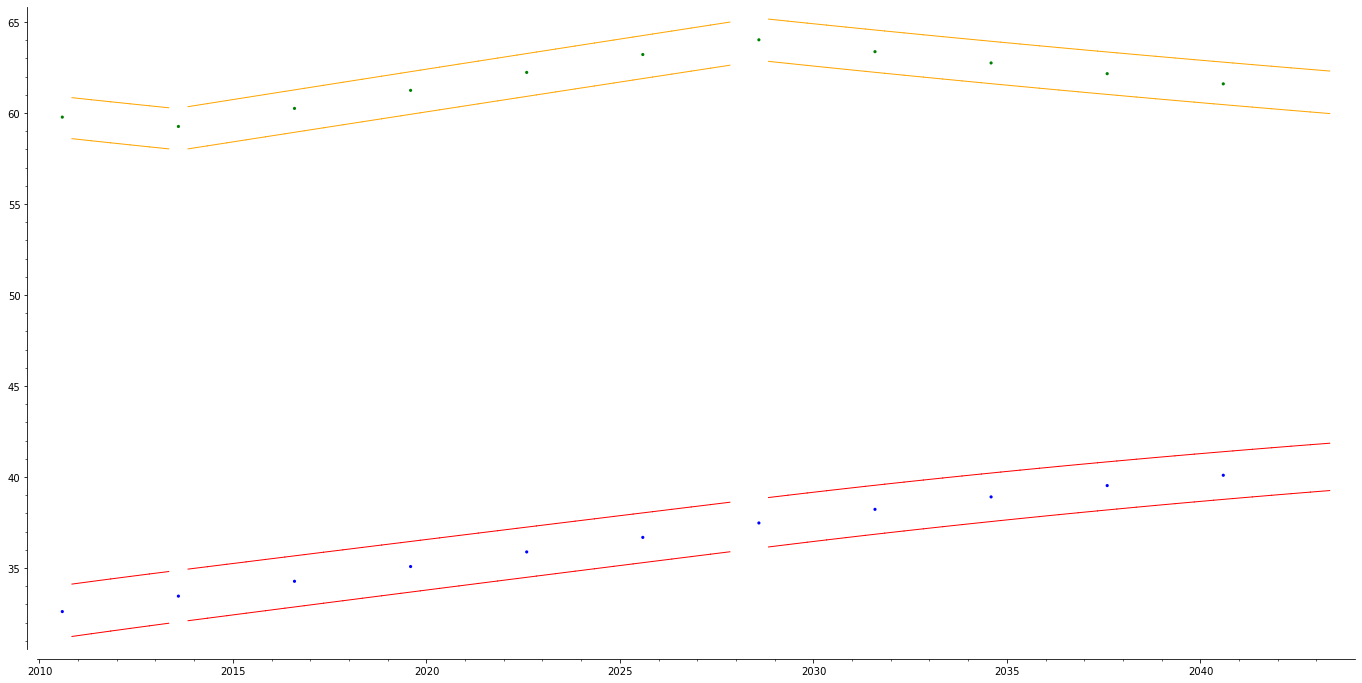

In [311]:
(  sg.points(zip(sol.y[0], sol.y[1]))
 + sg.points(zip(sol.y[0], sol.y[2]), color='green')
 + verified_trace3e.plot(('T_A', 'T_H'), color=('red', 'orange'))
).matplotlib()

### Experiment outcome

Parameters:
C_air:  [145.69782402, 141.71945977643318, 272.01832249938576, 102.28707795820601]
G_box:  [0.79154106, 7.8338353184845495, 8.315644265351954, 1.412942235649828]
C_heater:  [227.76228512, 227.76228512, 227.76228512, 227.76228512]
G_heater:  [1.92343277, 1.92343277, 1.92343277, 1.92343277]


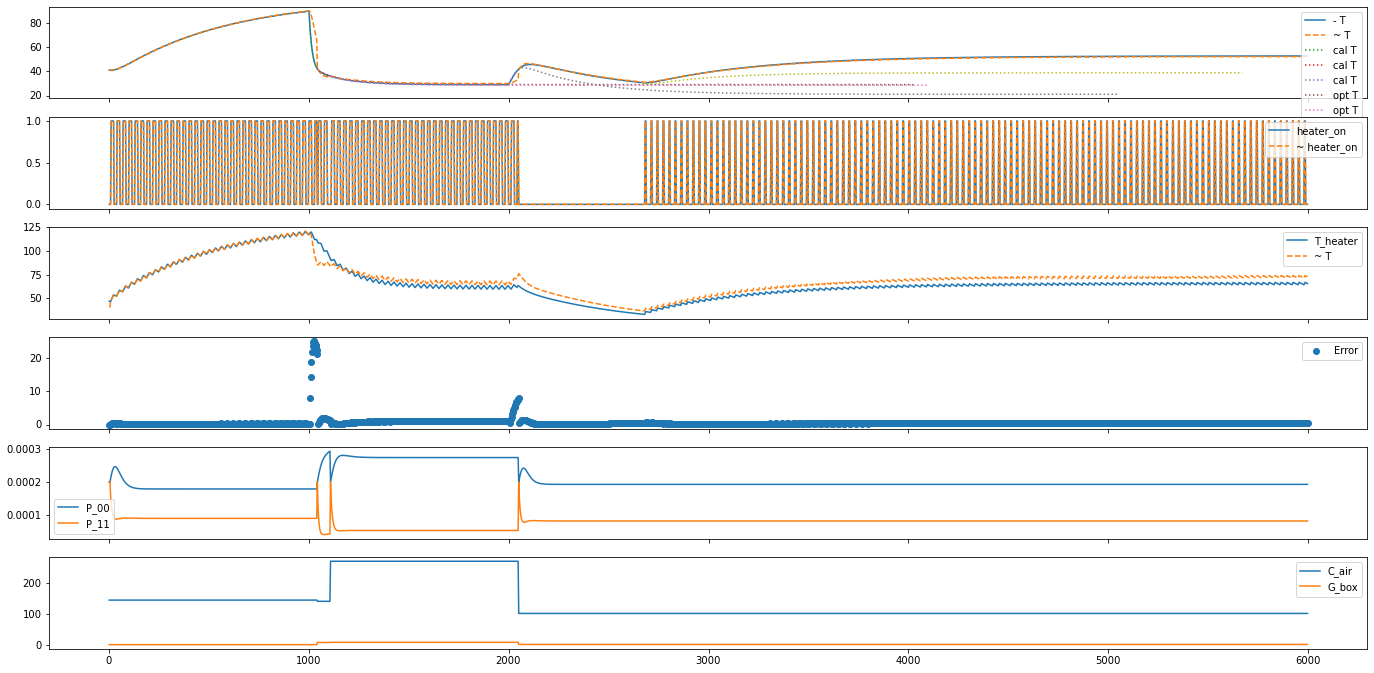

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex='all')

ax1.plot(m.signals['time'], m.physical_twin.plant.signals['T'], label=f"- T")
ax1.plot(m.signals['time'], m.kalman.signals['out_T'], linestyle="dashed", label=f"~ T")
# ax1.plot(m.signals['time'], m.kalman.signals['out_T_prior'], linestyle="dashed", label=f"~ T_prior")

for (times, trajectory) in database.plant_calibration_trajectory_history:
    ax1.plot(times, trajectory[0, :], label=f"cal T", linestyle='dotted')

for (times, T, T_heater, heater_on) in database.ctrl_optimal_policy_history:
    ax1.plot(times, T, label=f"opt T", linestyle='dotted')

ax1.legend()

ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.physical_twin.ctrl.signals['heater_on']], label=f"heater_on")
ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.kalman.signals['in_heater_on']], linestyle="dashed", label=f"~ heater_on")

ax2.legend()

ax3.plot(m.signals['time'], m.physical_twin.plant.signals['T_heater'], label=f"T_heater")
ax3.plot(m.signals['time'], m.kalman.signals['out_T_heater'], linestyle="dashed", label=f"~ T")

ax3.legend()

# The following plot is incorrect, since it does not match with the actual residual computed by the self_adaptation_manager
# ax4.scatter(m.signals['time'],
#             np.absolute(np.array(m.physical_twin.plant.signals['T']) - np.array(m.kalman.signals['out_T'])),
#             label=f"Error")

ax4.scatter(m.signals['time'],
            m.self_adaptation_manager.signals["temperature_residual_abs"],
            label=f"Error")
ax4.legend()

ax5.plot(m.signals['time'], m.kalman.signals['out_P_00'], label=f"P_00")
ax5.plot(m.signals['time'], m.kalman.signals['out_P_11'], label=f"P_11")

ax5.legend()

ax6.plot(m.signals['time'], m.kalman.signals['C_air'], label=f"C_air")
ax6.plot(m.signals['time'], m.kalman.signals['G_box'], label=f"G_box")

ax6.legend()

print("Parameters:")
print("C_air: ", database.C_air)
print("G_box: ", database.G_box)
print("C_heater: ", database.C_heater)
print("G_heater: ", database.G_heater)
plt.show()